In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
# maps pixel values between -1 and +1

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,),
                         std=(0.5,))])

# scale image back to (0, 1)
def scale_image(img):
  out = (img + 1) / 2
  return out

In [3]:
train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transform,
    download=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [9]:
len(train_dataset)


60000

In [10]:
batch_size = 128
data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

In [11]:
# Discriminator
D = nn.Sequential(
    nn.Linear(784, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    # nn.Sigmoid() # Cross Entropy Loss
)

In [12]:
# Generator
latent_dim = 100
G = nn.Sequential(
    nn.Linear(latent_dim, 256),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(256, momentum=0.7),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(512, momentum=0.7),
    nn.Linear(512, 1024),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(1024, momentum=0.7),
    nn.Linear(1024, 784),
    nn.Tanh()
)

In [17]:
# Models to Device
D = D.to(device)
G = G.to(device)

In [18]:
# Loss and optimizers
criterion = nn.BCEWithLogitsLoss() #Binary Cross Entropy with Logit Loss
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [21]:
!ls -l

total 12
drwxr-xr-x 2 root root 4096 Dec  3 14:58 gan_images
drwxr-xr-x 4 root root 4096 Dec  3 14:49 MNIST
drwxr-xr-x 1 root root 4096 Nov 13 17:33 sample_data


In [20]:
# Create a folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [22]:
# Training loop

# labels to use in the loop
ones_ = torch.ones(batch_size, 1).to(device)
zeros_ = torch.zeros(batch_size, 1).to(device)

# save losses
d_losses = []
g_losses = []

for epoch in range(200):
  for inputs, _ in data_loader:

    # reshape and move to GPU
    n = inputs.size(0)
    inputs = inputs.reshape(n, 784).to(device)

    # set ones and zeros to correct size
    ones = ones_[:n]
    zeros = zeros_[:n]

    ### Train discriminator ###
    
    real_outputs = D(inputs) # real images
    d_loss_real = criterion(real_outputs, ones)

    noise = torch.randn(n, latent_dim).to(device)
    fake_images = G(noise) # Generate fake images
    fake_outputs = D(fake_images)
    d_loss_fake = criterion(fake_outputs, zeros)

    d_loss = 0.5 * (d_loss_real + d_loss_fake) # Average loss
    d_optimizer.zero_grad()
    d_loss.backward() 
    d_optimizer.step() # Update Discriminator weights

    ### Train generator ###

    for _ in range(2):  # do it twice:
      noise = torch.randn(n, latent_dim).to(device) # fake images
      fake_images = G(noise) # Generate Fake images
      fake_outputs = D(fake_images) # Classify image real or fake

      
      g_loss = criterion(fake_outputs, ones) 


      g_optimizer.zero_grad()
      g_loss.backward()
      g_optimizer.step() # Update Generator weights

    # save losses
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())


  print(f"Epoch: {epoch}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

  # PyTorch has a function to save a batch of images to file
  fake_images = fake_images.reshape(-1, 1, 28, 28)
  save_image(scale_image(fake_images), f"gan_images/{epoch+1}.png")


Epoch: 0, d_loss: 0.6935839653015137, g_loss: 0.6636621356010437
Epoch: 1, d_loss: 0.706739068031311, g_loss: 0.6059465408325195
Epoch: 2, d_loss: 0.6861037015914917, g_loss: 0.7101272940635681
Epoch: 3, d_loss: 0.6870701313018799, g_loss: 0.69377201795578
Epoch: 4, d_loss: 0.6942270994186401, g_loss: 0.678374171257019
Epoch: 5, d_loss: 0.7041258215904236, g_loss: 0.6745852828025818
Epoch: 6, d_loss: 0.7019559741020203, g_loss: 0.6789914965629578
Epoch: 7, d_loss: 0.6907251477241516, g_loss: 0.7075868844985962
Epoch: 8, d_loss: 0.6806080341339111, g_loss: 0.6992177963256836
Epoch: 9, d_loss: 0.6884135603904724, g_loss: 0.7202731966972351
Epoch: 10, d_loss: 0.6921356916427612, g_loss: 0.6929421424865723
Epoch: 11, d_loss: 0.6867932677268982, g_loss: 0.7093652486801147
Epoch: 12, d_loss: 0.6881454586982727, g_loss: 0.6578612327575684
Epoch: 13, d_loss: 0.6983007192611694, g_loss: 0.6919421553611755
Epoch: 14, d_loss: 0.6857110261917114, g_loss: 0.7109488248825073
Epoch: 15, d_loss: 0.688

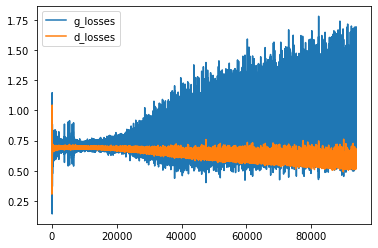

In [23]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

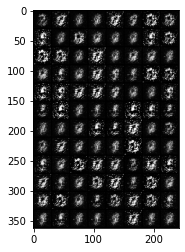

In [24]:
from skimage.io import imread
a = imread('gan_images/1.png')
plt.imshow(a)

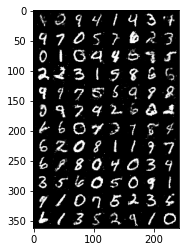

In [25]:
a = imread('gan_images/50.png')
plt.imshow(a)

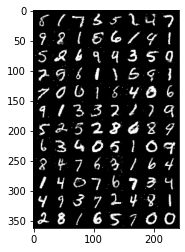

In [26]:
a = imread('gan_images/100.png')
plt.imshow(a)

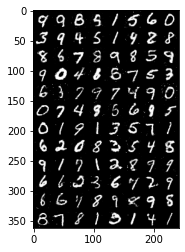

In [27]:
a = imread('gan_images/150.png')
plt.imshow(a)

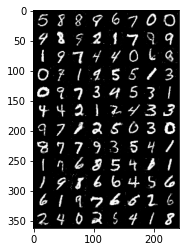

In [28]:
a = imread('gan_images/200.png')
plt.imshow(a)

In [38]:
from google.colab import files

files.download('gan_images/50.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>